In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

In [2]:
#path_BM_v4 = "../../../PhD_study/BM_v04/lc_notes/"
path_BM_v4 = '../../data/BigMedialytis/BM_v04/lc_notes/'


pat_treatment = pd.read_csv(path_BM_v4+'patient_oncologicalTreatmentLine.csv', delimiter=",")
pat_treatment_drug = pd.read_csv(path_BM_v4+'patient_oncologicalTreatmentLine_drugs.csv', delimiter=",")
pat_tox = pd.read_csv(path_BM_v4+'patient_toxicities.csv', delimiter=",")
pat_treatment_service = pd.read_csv(path_BM_v4+'patient_treatmentline_service.csv', delimiter=",")
pat_comorbidity_drug = pd.read_csv(path_BM_v4+'patient_nonOncologycalTreatments.csv', delimiter=",")

during_treat_line = pd.read_csv(path_BM_v4+'during_treatmentline.csv', delimiter=",")

replacement_mapping_dict = {
    'Enalaprile': 'Enalapril',
    'Atenolole': 'Atenolol',
    'Azitromicina': 'Azithromycin',
    'Immunoglobulin_g': 'Human_immunoglobulin_g',
}
pat_comorbidity_drug['drug_name'].replace(replacement_mapping_dict, inplace=True)
pat_comorbidity_drug = pat_comorbidity_drug.loc[~pat_comorbidity_drug.drug_name.isin(
    ['Antibiotic','Analgesic','Antibiotics','Insulin','Corticoids'])]



display(pat_treatment.shape, pat_treatment.head(2), pat_treatment_drug.shape, pat_treatment_drug.head(2),
        pat_tox.shape, pat_tox.head(2), pat_comorbidity_drug.shape, pat_comorbidity_drug.head(2),
        during_treat_line.shape, during_treat_line.head(2))

(1263, 19)

,patient_id,oncologicalTreatmentLine_id,type,lineNumber,initDate,finishDate,durationMonths,toxicities,toxGeneral,toxGastro,toxEndo,toxCut,toxNeumo,toxAnaly,toxNeuro,toxOther,localProgression,systemicProgression,brainMetastasis
0,1003706,693,qt,2,2017-04-28,2017-08-22,4,True,True,True,False,False,False,True,False,False,False,False,False
1,1007602,694,qt,1,2016-02-25,2016-03-01,0,True,True,True,False,False,False,False,False,False,False,False,True


(2012, 3)

,patient_id,oncologicalTreatmentLine_id,drug_name
0,1003706,693,Cisplatin
1,1003706,693,Docetaxel


(35278, 4)

,patient_id,toxicity_id,toxicity_concept,date
0,1003706,11945,Anemia,2017-08-14
1,1003706,11949,Anemia,2017-08-23


(1290, 2)

,patient_id,drug_name
0,1098173,Omeprazole
1,1098173,Ranitidine


(15191, 17)

,Id,MEDICALRECORD,SCOPE,PROCESS_START_DATE,DESCRIPTION_PROCESS,SERVICE,PROCESS_STATUS,START_DATE,END_DATE,STATUS_CLINIC_EVENT,TYPE,PROCESS_COMMENT,NumberDatesinService,NumberDatesPeriod,lineNumber,Service_Percentage,Desc_diagnost
0,2,1370231,Consultation,2015-01-08,ESTUDIO ENSAYO CLiNICO EC_(FIS/PIE),Medical_oncology,Active,2015-10-01,2015-10-01,Closed,External_consultations,NaN,1.0,120,2,0.008333,NaN
1,3,1370231,Consultation,2015-01-08,ESTUDIO ENSAYO CLiNICO EC_(FIS/PIE),Medical_oncology,Active,2015-10-13,2015-10-14,Closed,External_consultations,NaN,2.0,120,2,0.016667,NaN


### Removing patient from 'pat_treatment_service' where 'ESTADO_ACTO_CLINICO==CANCELLED'

In [3]:
procesos_actos_clinicos = pd.read_csv(path_BM_v4+'procesos_actos_clinicos_from_hospital_compressed.csv', delimiter=",")
procesos_actos_clinicos.rename(columns = {'MEDICALRECORD':'patient_id', 'AMBITO':'SCOPE', 'FEC_INI_PROCESO': 'initDate',
                                          'FECHA_FIN':'finishDate', 'FECHA_INICIO':'START_DATE','SERVICIO':'SERVICE'},
                               inplace = True)

procesos_actos_clinicos['START_DATE'] =  pd.to_datetime(procesos_actos_clinicos['START_DATE'])
pat_treatment_service['START_DATE'] =  pd.to_datetime(pat_treatment_service['START_DATE'])

procesos_actos_clinicos_CANCELLED = procesos_actos_clinicos.loc[procesos_actos_clinicos.ESTADO_ACTO_CLINICO=='CANCELLED']
procesos_actos_clinicos_CANCELLED = procesos_actos_clinicos_CANCELLED[['patient_id', 'SCOPE','START_DATE','SERVICE']]

pat_treatment_service = pd.merge(pat_treatment_service, procesos_actos_clinicos_CANCELLED, how='outer',
                   indicator='Exist')
pat_treatment_service = pat_treatment_service.loc[pat_treatment_service['Exist'] == 'left_only']
pat_treatment_service = pat_treatment_service.drop(columns=['Exist'])
pat_treatment_service.shape

(77155, 13)

In [4]:
during_treat_line = during_treat_line.loc[during_treat_line.STATUS_CLINIC_EVENT!='CANCELLED']
during_treat_line.rename(columns = {'MEDICALRECORD':'patient_id'}, inplace = True)
display(during_treat_line.shape)

(15191, 17)

In [51]:
BM_treatment = pd.read_csv('treatments/BM_treatment.csv', delimiter=",")
BM_treatment.head(2)

,patient_id,oncologicalTreatmentLine_id,treatment
0,1015121,698,"Cisplatin, Docetaxel, Gemcitabine, Pemetrexed,..."
1,621354,418,"Carboplatin, Docetaxel, Pemetrexed, Vinorelbin..."


In [47]:
for i in range(BM_treatment.shape[0]):
    p_id = BM_treatment.patient_id[i]
    line_id = BM_treatment.oncologicalTreatmentLine_id[i]
    line = pat_treatment.loc[(pat_treatment.patient_id==p_id) & 
                             (pat_treatment.oncologicalTreatmentLine_id==line_id)].lineNumber.values[0]

    service = pat_treatment_service.loc[(pat_treatment_service.patient_id==p_id) & 
                                        (pat_treatment_service.lineNumber==line) & 
                                        (pat_treatment_service.SCOPE=='Emergency')].drop(columns=
                                                                                         ['TYPE_SERVICE_EVENT'])
    service.drop_duplicates(keep = 'first', inplace=True)
    BM_treatment.at[i, 'Emergency'] = service.shape[0]

BM_treatment = BM_treatment[['treatment', 'Emergency']]
BM_treatment.drop_duplicates(keep = 'first', inplace=True)
BM_treatment = BM_treatment.sort_values(by=['Emergency'], ascending=False)
BM_treatment

,treatment,Emergency
107,"Carboplatin, Paclitaxel, Atorvastatin, Levoflo...",12.0
47,"Carboplatin, Etoposide, Atorvastatin, Enalapri...",8.0
14,"Cisplatin, Pemetrexed, Vinorelbine, Lorazepam,...",7.0
96,"Carboplatin, Etoposide, Ibuprofen, Omeprazole,...",6.0
93,"Carboplatin, Pemetrexed, Dexamethasone, Loraze...",5.0
...,...,...
62,"Carboplatin, Paclitaxel, Dexamethasone, Fentan...",0.0
61,"Cisplatin, Paclitaxel, Atorvastatin, Enalapril...",0.0
57,"Carboplatin, Etoposide, Atenolol, Atorvastatin...",0.0
56,"Carboplatin, Pemetrexed, Allopurinol, Amlodipi...",0.0


In [48]:
BM_treatment.Emergency.value_counts()

0.0     76
1.0     27
2.0     13
3.0      9
4.0      8
12.0     1
8.0      1
7.0      1
6.0      1
5.0      1
Name: Emergency, dtype: int64

In [49]:
BM_treatment.to_csv('treatments/BM_treatment_emergency.csv', index=False)

In [63]:
for i in range(BM_treatment.shape[0]):
    p_id = BM_treatment.patient_id[i]
    line_id = BM_treatment.oncologicalTreatmentLine_id[i]    
    line = pat_treatment.loc[(pat_treatment.patient_id==p_id) & 
                                 (pat_treatment.oncologicalTreatmentLine_id==line_id)]
    line = line[['toxGeneral', 'toxGastro', 'toxEndo', 'toxCut', 'toxNeumo', 'toxAnaly', 
                 'toxNeuro', 'toxOther']]
    BM_treatment.at[i, 'Toxicity'] = line.values[0].sum()

BM_treatment = BM_treatment[['treatment', 'Toxicity']]
BM_treatment.drop_duplicates(keep = 'first', inplace=True)
BM_treatment = BM_treatment.sort_values(by=['Toxicity'], ascending=False)
BM_treatment

,treatment,Toxicity
1,"Carboplatin, Docetaxel, Pemetrexed, Vinorelbin...",7.0
3,"Carboplatin, Docetaxel, Gemcitabine, Pemetrexe...",6.0
21,"Carboplatin, Etoposide, Vinorelbine, Atenolol,...",6.0
8,"Cisplatin, Docetaxel, Gemcitabine, Pemetrexed,...",6.0
26,"Carboplatin, Docetaxel, Pemetrexed, Omeprazole...",5.0
...,...,...
14,"Cisplatin, Pemetrexed, Vinorelbine, Lorazepam,...",0.0
127,"Carboplatin, Atorvastatin, Furosemide, Metform...",0.0
126,"Cisplatin, Acetaminophen, Atenolol, Fentanyl, ...",0.0
124,"Pemetrexed, Amoxicillin, Atenolol, Ceftriaxone...",0.0


In [64]:
BM_treatment.to_csv('treatments/BM_treatment_toxicity.csv', index=False)

# Removing comorbidity drugs duplicates by patient

In [5]:
pat_comorbidity_drug.drop_duplicates(keep = 'first', inplace=True)

# Select Oncological Treatment Line

In [6]:
lineNumber = 1
pat_line_x = pat_treatment.loc[pat_treatment.lineNumber==lineNumber]

pat_drug_line_x = pat_treatment_drug.loc[pat_treatment_drug.oncologicalTreatmentLine_id.isin(pat_line_x.oncologicalTreatmentLine_id)]
pat_drug_line_x

,patient_id,oncologicalTreatmentLine_id,drug_name
3,1007602,694,Carboplatin
4,1007602,694,Etoposide
6,1013426,696,Erlotinib
7,1013702,697,Carboplatin
8,1013702,697,Pemetrexed
...,...,...,...
2001,989249,684,Pemetrexed
2002,994263,686,Cisplatin
2006,998317,689,Cisplatin
2007,998317,689,Pemetrexed


# Selecting one ocological tretament

#### Find the most frecuent oncological treatment

In [7]:
df_drug = pat_drug_line_x.groupby(by=['patient_id','oncologicalTreatmentLine_id']).agg(lambda x: x.tolist()).reset_index()
for i in range(df_drug.shape[0]):
    df_drug.at[i,'drug_name']=sorted(df_drug.loc[i].drug_name)

df_drug = df_drug.sort_values(by=['drug_name'])
for i in range(df_drug.shape[0]):
    df_drug.at[i,'drug_name']='-'.join(df_drug.loc[i].drug_name)

df_drug.columns = ['patient_id', 'oncologicalTreatmentLine_id', 'col_drug']
df_drug.groupby("col_drug").count().sort_values(by=['patient_id'], ascending=False)
#df_drug.groupby("col_drug")["patient_id"].count()


,patient_id,oncologicalTreatmentLine_id
col_drug,,
Carboplatin-Etoposide,121,121
Cisplatin-Vinorelbine,118,118
Carboplatin-Paclitaxel,50,50
Carboplatin,44,44
Carboplatin-Pemetrexed,39,39
Cisplatin,38,38
Carboplatin-Vinorelbine,32,32
Cisplatin-Pemetrexed,21,21
Erlotinib,14,14


In [8]:
onco_treatment = 'Carboplatin-Etoposide'
#onco_treatment = 'Cisplatin-Vinorelbine'
#onco_treatment = 'Carboplatin-Paclitaxel'
treatmet_x = df_drug.loc[df_drug.col_drug==onco_treatment]

#### Find the most frecuent Non Oncological Drug in the selected treatment

In [9]:
treatmet_x_comorbidity = pat_comorbidity_drug.loc[pat_comorbidity_drug.patient_id.isin(treatmet_x.patient_id)]
treatmet_x_comorbidity.groupby("drugName").count().sort_values(by=['patient_id'], ascending=False)

,patient_id
drugName,
Omeprazole,54
Atorvastatin,27
Enalapril,24
Metformin,14
Simvastatin,13
Atenolol,12
Acetaminophen,9
Insulin,8
Ranitidine,7


In [10]:
def get_treatment_comorbidity(treatmet_x_comorbidity, comorb_a, comorb_b):
    x = treatmet_x_comorbidity.loc[treatmet_x_comorbidity.drugName.isin(comorb_a)].patient_id
    y = treatmet_x_comorbidity.loc[treatmet_x_comorbidity.drugName.isin(comorb_b)].patient_id
    z = treatmet_x_comorbidity.loc[treatmet_x_comorbidity.patient_id.isin(x)]
    z = z.loc[~z.patient_id.isin(y)]
    z = z.sort_values(by=['patient_id'])
    return z

### Get the set of  patients-toxicity by a treatment

In [11]:
def get_set_pat_toxicity(pat_tox, pat_line_x, pat_comorbidity_a_not_b, day_after_treatment):
    pat_tox['date'] =  pd.to_datetime(pat_tox['date'])
    pat_line_x['initDate'] =  pd.to_datetime(pat_line_x['initDate'])
    pat_line_x['finishDate'] =  pd.to_datetime(pat_line_x['finishDate'])

    pat_line_x_set_a = pat_line_x.loc[pat_line_x.patient_id.isin(pat_comorbidity_a_not_b)]
    pat_tox_set_a = pat_tox.loc[pat_tox.patient_id.isin(pat_comorbidity_a_not_b)]

    set_pat_toxicity = pd.DataFrame()
    for i in range(pat_line_x_set_a.shape[0]):    
        pat_id = pat_line_x_set_a.iloc[i]['patient_id']
        init_date = pat_line_x_set_a.iloc[i]['initDate']
        finish_date = pat_line_x_set_a.iloc[i]['finishDate']
        finish_date += DateOffset(days=day_after_treatment)

        a = pat_tox_set_a.loc[(pat_tox_set_a.patient_id==pat_id) & (pat_tox_set_a.date>=init_date) & 
                              (pat_tox_set_a.date<=finish_date)]
        set_pat_toxicity = pd.concat([set_pat_toxicity, a])
    
    set_pat_toxicity = set_pat_toxicity[['patient_id','toxicity_concept']]
    set_pat_toxicity.drop_duplicates(keep = 'first', inplace=True)
    return set_pat_toxicity

def plot_patient_tox(pat_toxicity_a, plot_name, n_pat):
    result = pat_toxicity_a.toxicity_concept.value_counts()
    plot_a = pd.DataFrame(result)
    left, width = .25, .7
    bottom, height = .25, .4
    right = left + width
    top = bottom + height
    
    tox_by_pat = round(pat_toxicity_a.shape[0]/n_pat, 3)
    ax = plot_a.plot.bar(rot=90, figsize=(6,5))
    ax.text(right, top, 'tox_by_pat='+str(tox_by_pat),
        horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,
           bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),))
    
    
    plt.title(plot_name+str(n_pat), fontsize=10, ha='center')
    plt.ylabel('num. patients')
    plt.tight_layout()
    plt.savefig(plot_name+'.png', format='png', dpi = 300)  # , format='png', dpi = 300
    plt.show()

### Get the set of  patients-service by a treatment

In [12]:
def pat_service(pat_id, during_treat_line):
    preprocess_serv = during_treat_line.loc[(during_treat_line.patient_id.isin(pat_id)) &
                                            (during_treat_line.lineNumber==1)]
    preprocess_serv = preprocess_serv.sort_values(by=['patient_id','START_DATE'])
    preprocess_serv = preprocess_serv[['patient_id', 'START_DATE', 'SERVICE']]
    preprocess_serv.drop_duplicates(keep = 'first', inplace=True)
    return preprocess_serv


def service_by_scope(scope, pat_id, pat_treatment_service):
    
    preprocess_serv = pat_treatment_service.loc[(pat_treatment_service.patient_id.isin(pat_id)) &
                                            (pat_treatment_service.lineNumber==1) & (pat_treatment_service.SCOPE==scope) &
                                            (pat_treatment_service.TYPE_SERVICE_EVENT=='IN')]
    preprocess_serv = preprocess_serv.sort_values(by=['patient_id','START_DATE'])
    preprocess_serv = preprocess_serv[['patient_id', 'START_DATE', 'SERVICE']]
    preprocess_serv.drop_duplicates(keep = 'first', inplace=True)
    return preprocess_serv

def plot_patient_serv(pat_service, plot_name, n_pat, rotation, dim):
    result = pat_service.SERVICE.value_counts()
    plot_a = pd.DataFrame(result)
    left, width = .25, .7
    bottom, height = .25, .4
    right = left + width
    top = bottom + height
    
    serv_by_pat = round(pat_service.shape[0]/n_pat, 3)
    ax = plot_a.plot.bar(rot=rotation, figsize=dim)
    ax.text(right, top, 'Hospital Services_by_pat='+str(serv_by_pat), horizontalalignment='right', verticalalignment='top',
            transform=ax.transAxes, bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),))
    
    
    plt.title(plot_name+str(n_pat), fontsize=10, ha='center')
    plt.ylabel('Hospital Services frequency')
    plt.tight_layout()
    plt.savefig('Hospital Services_'+plot_name+'.png', format='png', dpi = 300)  # , format='png', dpi = 300
    plt.show()

### Input Comorbidity drugs

In [13]:
comorb_a = ['Omeprazole', 'Ranitidine']
comorb_b = ['Enalapril', 'Atenolol']
comorb_c = ['Atorvastatin', 'Simvastatin']
c_a = "-".join(x for x in comorb_a)
c_b = "-".join(x for x in comorb_b)

In [14]:
class Treatment:

    def __init__(self, name):
        self.name = name
        self.toxicity = None
        self.service = None

    def add_toxicity(self, toxicity):
        self.toxicity = toxicity
    
    def add_service(self, service):
        self.service = service
    
    def get_frecuency_pat_tox(self, min_num):
        set_id = self.toxicity.patient_id.unique()
        set_id = np.random.choice(set_id, size=min_num, replace=False)
        
        set_tox = self.toxicity.loc[self.toxicity.patient_id.isin(set_id)]
        result = set_tox.toxicity_concept.value_counts()
        return result
    
    def get_frecuency_pat_serv(self, min_num):
        set_id = self.service.patient_id.unique()
        set_id = np.random.choice(set_id, size=min_num, replace=False)
        
        set_serv = self.service.loc[self.service.patient_id.isin(set_id)]
        serv_by_pat = round(set_serv.shape[0]/min_num, 3)
        
        result = set_serv.SERVICE.value_counts()
        return result, serv_by_pat
    
    def get_frecuency_pat_tox_replacement(self, max_num):
        set_id = self.toxicity.patient_id.unique()
        add_id = max_num - len(set_id)
        list_id_add = np.random.choice(set_id, size=add_id, replace=True)
        tox_pat_add = pd.DataFrame()
        for i in list_id_add:
            tox_pat_add = pd.concat([tox_pat_add, self.toxicity.loc[self.toxicity.patient_id==i]])
        set_tox = pd.concat([tox_pat_add, self.toxicity])
        result = set_tox.toxicity_concept.value_counts()
        return result
    
    def get_contingency_table_serv(self):
        result = self.pat_service.SERVICE.value_counts()
        return result

C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


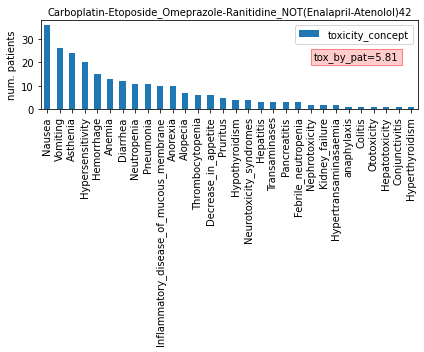

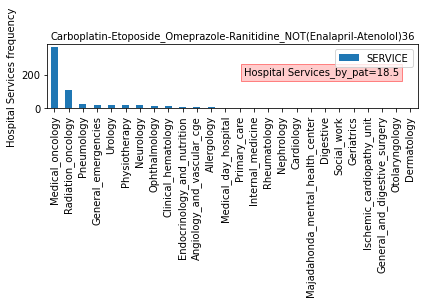

C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


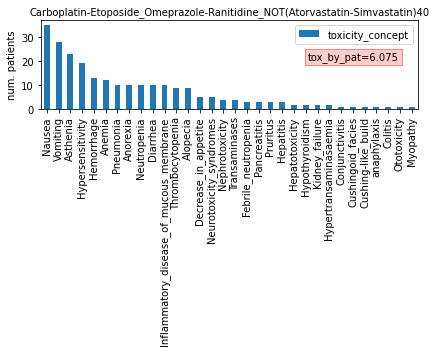

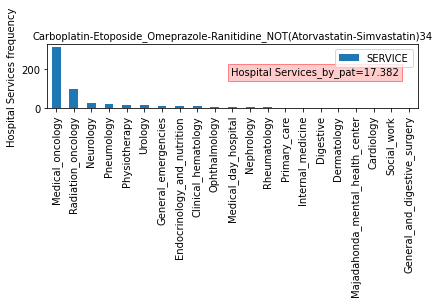

C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


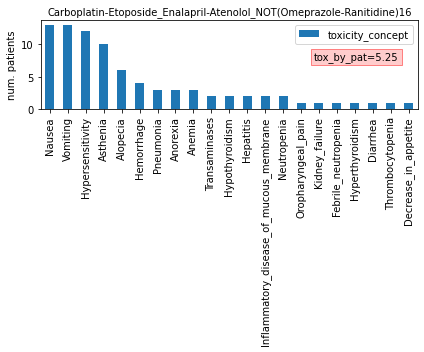

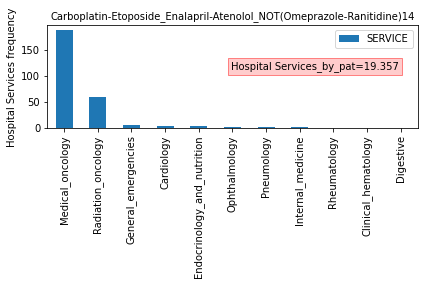

C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


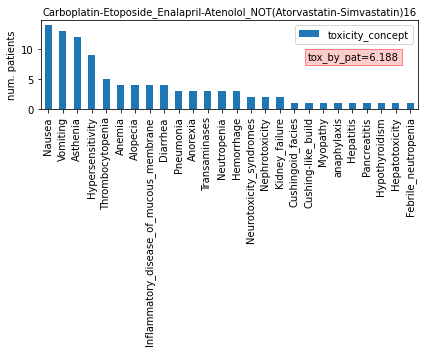

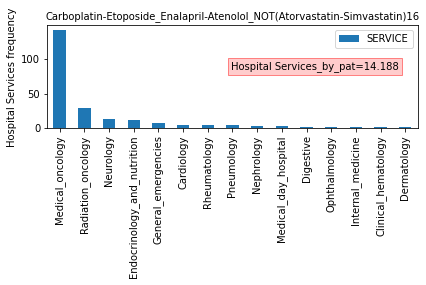

C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


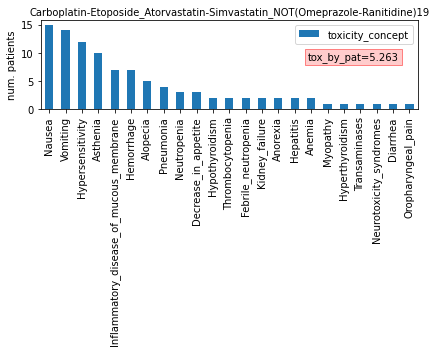

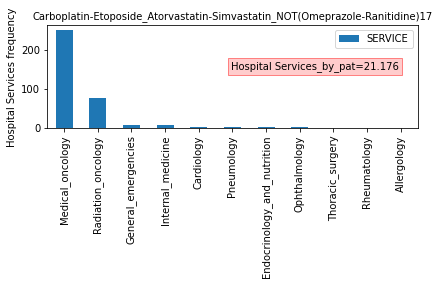

C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


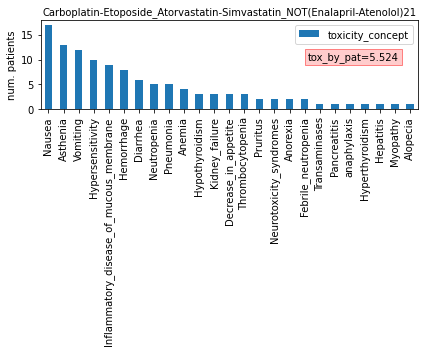

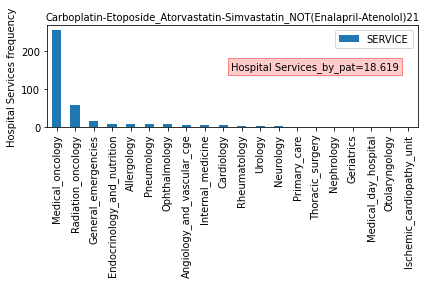

In [13]:
comorb_a = ['Omeprazole', 'Ranitidine']
comorb_b = ['Enalapril', 'Atenolol']
comorb_c = ['Atorvastatin', 'Simvastatin']
comorbidities = [comorb_a, comorb_b, comorb_c]
treatm = []
min_num = 100000
min_num_service = {}
#min_num_service['Emergency']=100000; min_num_service['Consultation']=100000; min_num_service['Hospital']=100000
min_num_service = 100000

for c1 in comorbidities:
    for c2 in comorbidities:
        if c1 == c2:
            continue
        c_a = "-".join(x for x in c1)
        c_b = "-".join(x for x in c2)
        t = Treatment(c_a+'_NOT('+c_b+')')
        
        z = get_treatment_comorbidity(treatmet_x_comorbidity, c1, c2)
        pat_toxicity_a = get_set_pat_toxicity(pat_tox, pat_line_x, z.patient_id.unique(), 7)
        num_pat = len(pat_toxicity_a.patient_id.unique())
        if min_num > num_pat:
            min_num = num_pat
        plot_patient_tox(pat_toxicity_a, onco_treatment+'_'+c_a+'_NOT('+c_b+')', num_pat)
        t.add_toxicity(pat_toxicity_a)
        
    
        preprocess_serv = pat_service(z.patient_id.unique(), during_treat_line)
        plot_patient_serv(preprocess_serv, onco_treatment+'_'+c_a+'_NOT('+c_b+')', len(preprocess_serv.patient_id.unique()),
                          90, (6,4))
        num_pat = len(preprocess_serv.patient_id.unique())
        if min_num_service > num_pat:
            min_num_service = num_pat
        t.add_service(preprocess_serv)
        """
        for scope in ['Emergency', 'Consultation', 'Hospital']:
            preprocess_serv = pat_service(scope, z.patient_id.unique(), during_treat_line)
            plot_patient_serv(preprocess_serv, onco_treatment+'_'+c_a+'_NOT('+c_b+')', len(preprocess_serv.patient_id.unique()),
                              scope, 90, (6,4))
            num_pat = len(preprocess_serv.patient_id.unique())
            if min_num_service[scope] > num_pat:
                min_num_service[scope] = num_pat
            t.add_service(scope, preprocess_serv)
        """
        treatm.append(t)

In [14]:
def get_contingency_table_tox(treatm, min_num):
    experiment_result = pd.DataFrame()
    for t in treatm:
        #result = t.get_frecuency_pat_tox_replacement(min_num)
        result = t.get_frecuency_pat_tox(min_num)
        df = result.to_frame().T
        df.rename(index={'toxicity_concept':t.name}, inplace=True)
        experiment_result = pd.concat([experiment_result, df])

    experiment_result = experiment_result.fillna(0)
    return experiment_result

In [14]:
def get_contingency_table_serv(treatm, min_num_service):
    experiment_result = pd.DataFrame()
    service_pat = {}
    for t in treatm:
        result, serv_by_pat = t.get_frecuency_pat_serv(min_num_service)
        service_pat[t.name] = serv_by_pat
        df = result.to_frame().T
        df.rename(index={'SERVICE':t.name}, inplace=True)
        experiment_result = pd.concat([experiment_result, df])

    experiment_result = experiment_result.fillna(0)
    return experiment_result, service_pat

In [66]:
min_num_service

14

In [16]:
experiment_result, service_pat = get_contingency_table_serv(treatm, min_num_service)
display(experiment_result, service_pat)

,Medical_oncology,Radiation_oncology,Clinical_hematology,Pneumology,Ophthalmology,Neurology,General_emergencies,Medical_day_hospital,Cardiology,Urology,...,Ischemic_cardiopathy_unit,Physiotherapy,Internal_medicine,Primary_care,Digestive,Majadahonda_mental_health_center,Dermatology,Social_work,Thoracic_surgery,Otolaryngology
Omeprazole-Ranitidine_NOT(Enalapril-Atenolol),137,57,12.0,10,9,6.0,5,3.0,3,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Omeprazole-Ranitidine_NOT(Atorvastatin-Simvastatin),96,44,0.0,6,9,11.0,10,5.0,2,17.0,...,0.0,18.0,4.0,4.0,2.0,2.0,1.0,1.0,0.0,0.0
Enalapril-Atenolol_NOT(Omeprazole-Ranitidine),188,59,1.0,2,2,0.0,7,0.0,4,0.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Enalapril-Atenolol_NOT(Atorvastatin-Simvastatin),130,29,1.0,2,1,13.0,6,0.0,4,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
Atorvastatin-Simvastatin_NOT(Omeprazole-Ranitidine),224,75,0.0,1,2,0.0,8,0.0,4,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Atorvastatin-Simvastatin_NOT(Enalapril-Atenolol),164,40,0.0,6,7,2.0,12,1.0,3,2.0,...,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


{'Omeprazole-Ranitidine_NOT(Enalapril-Atenolol)': 18.071,
 'Omeprazole-Ranitidine_NOT(Atorvastatin-Simvastatin)': 17.071,
 'Enalapril-Atenolol_NOT(Omeprazole-Ranitidine)': 19.357,
 'Enalapril-Atenolol_NOT(Atorvastatin-Simvastatin)': 14.429,
 'Atorvastatin-Simvastatin_NOT(Omeprazole-Ranitidine)': 22.929,
 'Atorvastatin-Simvastatin_NOT(Enalapril-Atenolol)': 18.643}

In [17]:
print(treatm[0].name, len(treatm[0].service.patient_id.unique()))

Omeprazole-Ranitidine_NOT(Enalapril-Atenolol) 36


In [117]:
#experiment_result = get_contingency_table_tox(treatm, 42)
print(min_num)
experiment_result = get_contingency_table_tox(treatm, min_num)
display(experiment_result)

16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Alopecia,Anemia,Anorexia,Asthenia,Conjunctivitis,Cushing-like_build,Cushingoid_facies,Decrease_in_appetite,Diarrhea,Febrile_neutropenia,...,Neutropenia,Oropharyngeal_pain,Ototoxicity,Pancreatitis,Pneumonia,Pruritus,Thrombocytopenia,Transaminases,Vomiting,anaphylaxis
Omeprazole-Ranitidine_NOT(Enalapril-Atenolol),5.0,7,2,6,0.0,0.0,0.0,2.0,5,1.0,...,3,0.0,1.0,1.0,3,0.0,2,1.0,11,1.0
Omeprazole-Ranitidine_NOT(Atorvastatin-Simvastatin),3.0,7,3,10,1.0,0.0,0.0,4.0,4,0.0,...,4,0.0,1.0,1.0,7,1.0,6,2.0,11,0.0
Enalapril-Atenolol_NOT(Omeprazole-Ranitidine),6.0,3,3,10,0.0,0.0,0.0,1.0,1,1.0,...,2,1.0,0.0,0.0,3,0.0,1,2.0,13,0.0
Enalapril-Atenolol_NOT(Atorvastatin-Simvastatin),4.0,4,3,12,0.0,1.0,1.0,0.0,4,1.0,...,3,0.0,0.0,1.0,3,0.0,5,3.0,13,1.0
Atorvastatin-Simvastatin_NOT(Omeprazole-Ranitidine),4.0,2,2,8,0.0,0.0,0.0,3.0,1,2.0,...,2,1.0,0.0,0.0,4,0.0,1,0.0,11,0.0
Atorvastatin-Simvastatin_NOT(Enalapril-Atenolol),0.0,3,1,9,0.0,0.0,0.0,1.0,4,1.0,...,4,0.0,0.0,1.0,2,1.0,3,1.0,10,0.0


### Output Toxicity Study

C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Num.patients in treatment:  21
Num.patients with toxicity:  21


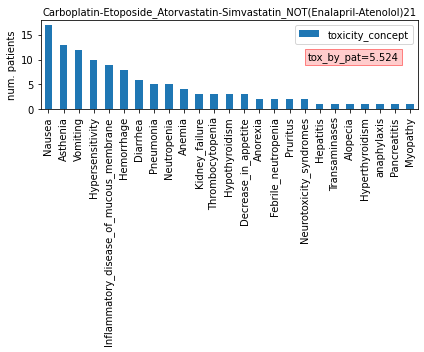

In [13]:
z = get_treatment_comorbidity(treatmet_x_comorbidity, comorb_a, comorb_b)
pat_toxicity_a = get_set_pat_toxicity(pat_tox, pat_line_x, z.patient_id.unique(), 7)
print('Num.patients in treatment: ', len(z.patient_id.unique()))
print('Num.patients with toxicity: ', len(pat_toxicity_a.patient_id.unique()))
plot_patient_tox(pat_toxicity_a, onco_treatment+'_'+c_a+'_NOT('+c_b+')', len(pat_toxicity_a.patient_id.unique()))

### Output Service Study by Scope

In [15]:
pat_treatment_service

,patient_id,initDate,finishDate,START_DATE,oncologicalTreatmentLine_id,lineNumber,SCOPE,DESCRIPTION_PROCESS,SERVICE,TYPE,PROCESS_STATUS,TYPE_SERVICE_EVENT,Desc_diagnost
0,1370231,9/15/2015,1/12/2016,2015-10-01,235.0,2.0,Consultation,ESTUDIO ENSAYO CLiNICO EC_(FIS/PIE),Medical Oncology,EXTERNAL_CONSULTATIONS,active,IN,NaN
1,1370231,9/15/2015,1/12/2016,2015-10-01,235.0,2.0,Consultation,ONC_CA_PULMON,Medical Oncology,EXTERNAL_CONSULTATIONS,active,IN,NaN
2,1370231,2/17/2015,3/31/2015,2015-10-01,234.0,1.0,Consultation,ESTUDIO ENSAYO CLiNICO EC_(FIS/PIE),Medical Oncology,EXTERNAL_CONSULTATIONS,active,AFTER,NaN
3,1370231,9/15/2015,1/12/2016,2015-10-01,235.0,2.0,Consultation,ESTUDIO ENSAYO CLiNICO EC_(FIS/PIE),Medical Oncology,EXTERNAL_CONSULTATIONS,active,AFTER,NaN
4,1370231,2/17/2015,3/31/2015,2015-10-01,234.0,1.0,Consultation,ONC_CA_PULMON,Medical Oncology,EXTERNAL_CONSULTATIONS,active,AFTER,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97088,2826513,7/19/2019,10/1/2019,2019-12-05,693.0,1.0,Consultation,CEX Oncologia Radioterapica,Radiation Oncology,EXTERNAL_CONSULTATIONS,active,AFTER,NaN
97089,2826513,7/19/2019,10/1/2019,2019-11-21,693.0,1.0,Consultation,CEX Oncologia Radioterapica,Radiation Oncology,EXTERNAL_CONSULTATIONS,active,AFTER,NaN
97090,2826513,7/19/2019,10/1/2019,2019-11-14,693.0,1.0,Consultation,CEX Oncologia Radioterapica,Radiation Oncology,EXTERNAL_CONSULTATIONS,active,AFTER,NaN
97091,2826513,7/19/2019,10/1/2019,2019-11-11,693.0,1.0,Consultation,CEX Oncologia Radioterapica,Radiation Oncology,EXTERNAL_CONSULTATIONS,active,AFTER,NaN


Num.patients attend Emergency:  4


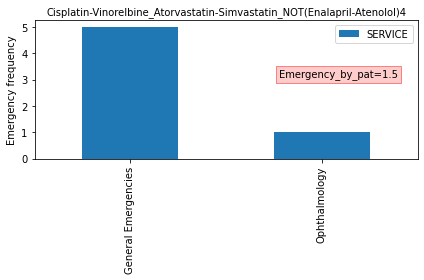

Num.patients attend Consultation:  9


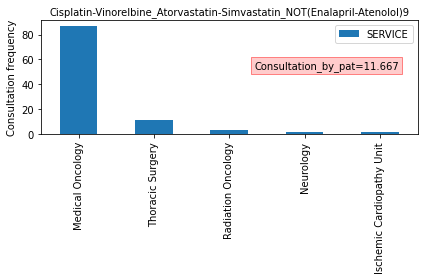

Num.patients attend Hospital:  4


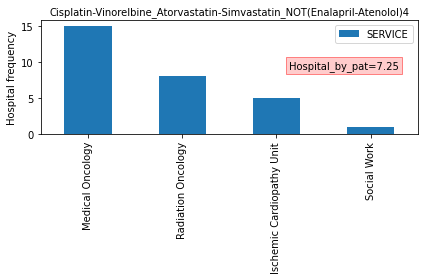

In [29]:
for scope in ['Emergency', 'Consultation', 'Hospital']:
    preprocess_serv = service_by_scope(scope, z.patient_id.unique(), pat_treatment_service)
    print('Num.patients attend '+scope+': ', len(preprocess_serv.patient_id.unique()))
    plot_patient_serv(preprocess_serv, onco_treatment+'_'+c_a+'_NOT('+c_b+')', len(preprocess_serv.patient_id.unique()),
                      scope, 90, (6,4))
    #preprocess_serv.head()

In [74]:
# generate two independent samples
comorb_a_not_b = [10, 5.81, 2.0, 15.286, 4.15]
comorb_b_not_a = [4, 5.25, 1.667, 14.786, 4.33]
comorb_a_not_c = [10, 6.075, 1.818, 14.364, 3.941]
comorb_c_not_a = [7, 5.263, 1.75, 17.059, 3.917]
comorb_b_not_c = [4, 6.188, 1.4, 10.125, 4.25]
comorb_c_not_b = [7, 5.524, 1.9, 14.571, 4.143]

In [77]:
# generate two independent samples
comorb_a_not_b = [10, 5.81, 2.0, 16.528]
comorb_b_not_a = [4, 5.25, 1.667, 16.571]
comorb_a_not_c = [10, 6.075, 1.818, 15.324]
comorb_c_not_a = [7, 5.263, 1.75, 18.529]
comorb_b_not_c = [4, 6.188, 1.4, 11.875]
comorb_c_not_b = [7, 5.524, 1.9, 16.524]

# Friedman Test

In [18]:
x = [experiment_result.iloc[0].values, experiment_result.iloc[1].values,
                            experiment_result.iloc[2].values, experiment_result.iloc[3].values,
                            experiment_result.iloc[4].values, experiment_result.iloc[5].values]

data = np.array(x)

In [19]:
# Friedman test
from scipy.stats import friedmanchisquare

# compare samples
#stat, p = friedmanchisquare(comorb_a_not_b, comorb_b_not_a, comorb_a_not_c, comorb_c_not_a, comorb_b_not_c, comorb_c_not_b)
stat, p = friedmanchisquare(*data)
print('Statistics=%.4f, p=%.10f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=8.5795, p=0.1270563540
Same distributions (fail to reject H0)


# Post hoc test and Significance plots

C:\Users\rivasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':


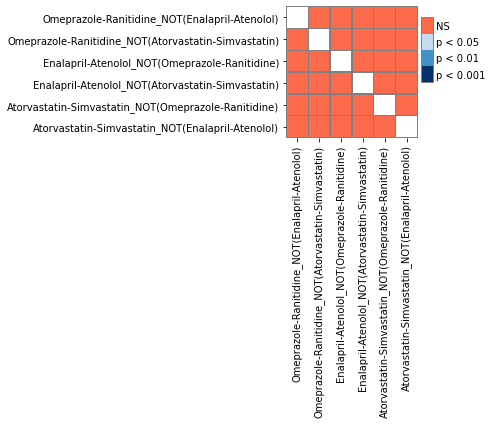

In [78]:
import scikit_posthocs as sp
#x = [comorb_a_not_b, comorb_b_not_a, comorb_a_not_c, comorb_c_not_a, comorb_b_not_c, comorb_c_not_b]
col = experiment_result.index
p_adjust = ['bonferroni', 'sidak', 'holm-sidak','holm','simes-hochberg','hommel','fdr_bh','fdr_by','fdr_tsbh','fdr_tsbky']
pc = sp.posthoc_conover_friedman(experiment_result.T)  #p_adjust=p_adjust[0]
pc.columns=col
pc.index=col
cmap = ['1', '#fb6a4a', '#08306b', '#4292c6', '#c6dbef',]
heatmap_args = {'cmap':cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square':True, 'cbar_ax_bbox': [0.81, 0.80, 0.02, 0.15]}
plt.figure(figsize=(8,6))
sp.sign_plot(pc, **heatmap_args)
plt.tight_layout()

plt.savefig('Significance_plots_Hospital.png', format='png', dpi = 300)
#[0.80, 0.35, 0.04, 0.3]}

In [21]:
pc

,Omeprazole-Ranitidine_NOT(Enalapril-Atenolol),Omeprazole-Ranitidine_NOT(Atorvastatin-Simvastatin),Enalapril-Atenolol_NOT(Omeprazole-Ranitidine),Enalapril-Atenolol_NOT(Atorvastatin-Simvastatin),Atorvastatin-Simvastatin_NOT(Omeprazole-Ranitidine),Atorvastatin-Simvastatin_NOT(Enalapril-Atenolol)
Omeprazole-Ranitidine_NOT(Enalapril-Atenolol),1.000000,0.053163,0.716264,1.000000,0.716264,0.401053
Omeprazole-Ranitidine_NOT(Atorvastatin-Simvastatin),0.053163,1.000000,0.104416,0.053163,0.104416,0.235949
Enalapril-Atenolol_NOT(Omeprazole-Ranitidine),0.716264,0.104416,1.000000,0.716264,1.000000,0.628555
Enalapril-Atenolol_NOT(Atorvastatin-Simvastatin),1.000000,0.053163,0.716264,1.000000,0.716264,0.401053
Atorvastatin-Simvastatin_NOT(Omeprazole-Ranitidine),0.716264,0.104416,1.000000,0.716264,1.000000,0.628555
Atorvastatin-Simvastatin_NOT(Enalapril-Atenolol),0.401053,0.235949,0.628555,0.401053,0.628555,1.000000


In [341]:
sp.posthoc_nemenyi_friedman(data.T)

,0,1,2,3,4,5
0,1.000000,0.853808,0.049661,0.900000,0.797649,0.835087
1,0.853808,1.000000,0.001000,0.647897,0.168456,0.193311
2,0.049661,0.001000,1.000000,0.125002,0.573021,0.535582
3,0.900000,0.647897,0.125002,1.000000,0.900000,0.900000
4,0.797649,0.168456,0.573021,0.900000,1.000000,0.900000
5,0.835087,0.193311,0.535582,0.900000,0.900000,1.000000


In [342]:
sp.posthoc_conover(data, val_col='values', group_col='groups')

,1,2,3,4,5,6
1,1.000000,0.667245,0.069191,0.832593,0.530241,0.655985
2,0.667245,1.000000,0.025058,0.521466,0.290745,0.381705
3,0.069191,0.025058,1.000000,0.107809,0.232214,0.168850
4,0.832593,0.521466,0.107809,1.000000,0.677066,0.814853
5,0.530241,0.290745,0.232214,0.677066,1.000000,0.855294
6,0.655985,0.381705,0.168850,0.814853,0.855294,1.000000


In [79]:
experiment_result.sum(axis=1)/8

Omeprazole-Ranitidine_NOT(Enalapril-Atenolol)          4.125
Omeprazole-Ranitidine_NOT(Atorvastatin-Simvastatin)    2.875
Enalapril-Atenolol_NOT(Omeprazole-Ranitidine)          4.750
Enalapril-Atenolol_NOT(Atorvastatin-Simvastatin)       4.250
Atorvastatin-Simvastatin_NOT(Omeprazole-Ranitidine)    4.125
Atorvastatin-Simvastatin_NOT(Enalapril-Atenolol)       3.125
dtype: float64

In [62]:
experiment_result

,Medical Oncology,Urology,Radiation Oncology,Physiotherapy,Neurology,General Emergencies,Pneumology,Endocrinology and Nutrition,Primary Care,Digestive,...,Internal Medicine,Ophthalmology,Rheumatology,Cardiology,Rehabilitation,Biochemistry Laboratory,Nephrology,Allergology,Angiology and Vascular CGE,Thoracic Surgery
Omeprazole-Ranitidine_NOT(Enalapril-Atenolol),116,30.0,19,13.0,7.0,4.0,4,3,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Omeprazole-Ranitidine_NOT(Atorvastatin-Simvastatin),72,0.0,29,0.0,12.0,0.0,7,5,0.0,0.0,...,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Enalapril-Atenolol_NOT(Omeprazole-Ranitidine),131,0.0,63,0.0,0.0,1.0,1,3,0.0,1.0,...,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
Enalapril-Atenolol_NOT(Atorvastatin-Simvastatin),82,0.0,29,0.0,12.0,0.0,1,9,0.0,2.0,...,1.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
Atorvastatin-Simvastatin_NOT(Omeprazole-Ranitidine),180,0.0,76,0.0,0.0,1.0,3,2,0.0,0.0,...,6.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Atorvastatin-Simvastatin_NOT(Enalapril-Atenolol),110,2.0,38,0.0,0.0,5.0,3,6,1.0,0.0,...,0.0,2.0,3.0,1.0,0.0,0.0,0.0,5.0,3.0,1.0


In [64]:
def rankdata(a, method='average', *, axis=None):
    if method not in ('average', 'min', 'max', 'dense', 'ordinal'):
        raise ValueError('unknown method "{0}"'.format(method))

    if axis is not None:
        a = np.asarray(a)
        if a.size == 0:
            # The return values of `normalize_axis_index` are ignored.  The
            # call validates `axis`, even though we won't use it.
            # use scipy._lib._util._normalize_axis_index when available
            np.core.multiarray.normalize_axis_index(axis, a.ndim)
            dt = np.float64 if method == 'average' else np.int_
            return np.empty(a.shape, dtype=dt)
        return np.apply_along_axis(rankdata, axis, a, method)

    arr = np.ravel(np.asarray(a))
    algo = 'mergesort' if method == 'ordinal' else 'quicksort'
    sorter = np.argsort(arr, kind=algo)

    inv = np.empty(sorter.size, dtype=np.intp)
    inv[sorter] = np.arange(sorter.size, dtype=np.intp)

    if method == 'ordinal':
        return inv + 1

    arr = arr[sorter]
    obs = np.r_[True, arr[1:] != arr[:-1]]
    dense = obs.cumsum()[inv]

    if method == 'dense':
        return dense

    # cumulative counts of each unique value
    count = np.r_[np.nonzero(obs)[0], len(obs)]

    if method == 'max':
        return count[dense]

    if method == 'min':
        return count[dense - 1] + 1

    # average method
    return .5 * (count[dense] + count[dense - 1] + 1)


def _contains_nan(a, nan_policy='propagate'):
    policies = ['propagate', 'raise', 'omit']
    if nan_policy not in policies:
        raise ValueError("nan_policy must be one of {%s}" %
                         ', '.join("'%s'" % s for s in policies))
    try:
        # Calling np.sum to avoid creating a huge array into memory
        # e.g. np.isnan(a).any()
        with np.errstate(invalid='ignore'):
            contains_nan = np.isnan(np.sum(a))
    except TypeError:
        # This can happen when attempting to sum things which are not
        # numbers (e.g. as in the function `mode`). Try an alternative method:
        try:
            contains_nan = np.nan in set(a.ravel())
        except TypeError:
            # Don't know what to do. Fall back to omitting nan values and
            # issue a warning.
            contains_nan = False
            nan_policy = 'omit'
            warnings.warn("The input array could not be properly "
                          "checked for nan values. nan values "
                          "will be ignored.", RuntimeWarning)

    if contains_nan and nan_policy == 'raise':
        raise ValueError("The input contains nan values")

    return contains_nan, nan_policy

def tiecorrect(rankvals):
    
    arr = np.sort(rankvals)
    idx = np.nonzero(np.r_[True, arr[1:] != arr[:-1], True])[0]
    cnt = np.diff(idx).astype(np.float64)

    size = np.float64(arr.size)
    return 1.0 if size < 2 else 1.0 - (cnt**3 - cnt).sum() / (size**3 - size)


def kruskal(*args, nan_policy='propagate'):
    args = list(map(np.asarray, args))

    num_groups = len(args)
    if num_groups < 2:
        raise ValueError("Need at least two groups in stats.kruskal()")

    for arg in args:
        if arg.size == 0:
            return KruskalResult(np.nan, np.nan)
        elif arg.ndim != 1:
            raise ValueError("Samples must be one-dimensional.")

    n = np.asarray(list(map(len, args)))
    print(n)
    if nan_policy not in ('propagate', 'raise', 'omit'):
        raise ValueError("nan_policy must be 'propagate', 'raise' or 'omit'")

    contains_nan = False
    for arg in args:
        cn = _contains_nan(arg, nan_policy)
        print(arg)
        if cn[0]:
            contains_nan = True
            break

    if contains_nan and nan_policy == 'omit':
        for a in args:
            a = ma.masked_invalid(a)
        return mstats_basic.kruskal(*args)

    if contains_nan and nan_policy == 'propagate':
        return KruskalResult(np.nan, np.nan)

    alldata = np.concatenate(args)
    ranked = rankdata(alldata)
    print(ranked)
    ties = tiecorrect(ranked)
    print(ties)
    if ties == 0:
        raise ValueError('All numbers are identical in kruskal')

    # Compute sum^2/n for each group and sum
    j = np.insert(np.cumsum(n), 0, 0)
    ssbn = 0
    for i in range(num_groups):
        ssbn += _square_of_sums(ranked[j[i]:j[i+1]]) / n[i]

    totaln = np.sum(n, dtype=float)
    h = 12.0 / (totaln * (totaln + 1)) * ssbn - 3 * (totaln + 1)
    df = num_groups - 1
    h /= ties

    return KruskalResult(h, distributions.chi2.sf(h, df))

In [65]:
x = ['fg', 'dfg', 'df', 'dfg', 'k,lbn']
y = ['g', 'hgj', 'fgh', 'k,j', 'tyf']
kruskal(x, y)

[5 5]
['fg' 'dfg' 'df' 'dfg' 'k,lbn']
['g' 'hgj' 'fgh' 'k,j' 'tyf']
[ 4.   2.5  1.   2.5  9.   6.   7.   5.   8.  10. ]
0.9939393939393939


NameError: name '_square_of_sums' is not defined